In [1]:
!pip install pysal
!pip install scikit-learn --upgrade

import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights.util import min_threshold_distance
from pysal.lib import cg as geometry
from pysal.viz import splot
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from pysal.explore import esda
from pysal.lib import weights
from splot import esda as esdaplot
from shapely import wkt
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, ParameterGrid, GridSearchCV, LeaveOneGroupOut

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 67.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Plots for lit review

<ipython-input-2-013e82e45ed8>:21: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = weights.contiguity.Queen.from_dataframe(geo_gdf)
/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 131.
  W.__init__(self, neighbors, ids=ids, **kw)


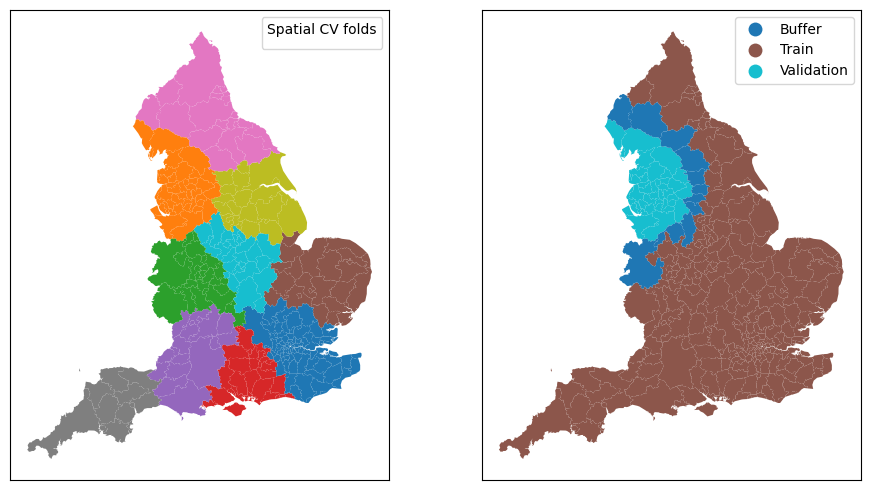

In [2]:
### plots for demonstrating spatial CV ########################################
data = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/diss_data2.csv')
geo = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/lads.csv')
geo['geometry'] = geo['geometry'].apply(wkt.loads)
geo_gdf = gpd.GeoDataFrame(geo)
gdf = geo_gdf.copy()
# getting centroids from geometries scale is in meters (British National Grid CRS (EPSG: 27700) )
gdf.geometry = gdf.geometry.centroid
gdf.set_crs('EPSG:27700', inplace=True)
gdf['x'] =  gdf.geometry.centroid.x
gdf['y'] = gdf.geometry.centroid.y
# Setting value for k
k = 10

# Extract centroids as X, where X is a matrix of coordinates
Xcoord = geo_gdf.centroid.x.to_numpy().reshape(-1, 1)
Ycoord = geo_gdf.centroid.y.to_numpy().reshape(-1, 1)
centroids = np.hstack((Xcoord, Ycoord))

# Creating weights using queen contiguity
w_queen = weights.contiguity.Queen.from_dataframe(geo_gdf)

# Adding closest neighbour to LA 131 as it is an island
neighbors = w_queen.neighbors.copy()
neighbors[131].append(102)
neighbors[102].append(131)
w_queen = weights.W(neighbors)

# Row-standardization
w_queen.transform = "R"

# Perform K-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(centroids)

# Assign cluster labels to GeoDataFrame
geo_gdf['cluster_label'] = kmeans.labels_

# add buffer to test cluster ##################################################

X = data.drop(columns=['local_authority', 'active']).values
y = data['active'].values

# Create group labels based on cluster labels
group_labels = geo_gdf['cluster_label'].values

# use LeaveOneGroupOut CV to create test regions with a buffer of one local authority
logo = LeaveOneGroupOut()
index_in = []
index_out = []
index_buffer = []

for fold, (train_index, test_index) in enumerate(logo.split(X, y, groups=group_labels)):
    test_neighbours = {k: v for k, v in w_queen.neighbors.items() if k in test_index}
    unique_neighbours = set()
    for values in test_neighbours.values():
        unique_neighbours.update(values)
    neighbors_array = list(unique_neighbours)
    values_in = train_index[~np.isin(train_index, neighbors_array)]
    index_in.append(values_in)
    index_out.append(test_index)
    index_buffer.append(train_index[np.isin(train_index, neighbors_array)])

### Using first cluster to create plots
# Creating plot indicating test train and buffer regions for cluster 1
in_gdf = geo_gdf.iloc[index_in[1]].copy()
out_gdf = geo_gdf.iloc[index_out[1]].copy()
buff_gdf = geo_gdf.iloc[index_buffer[1]].copy()
in_gdf['grouping'] = 'Train'
out_gdf['grouping'] = 'Validation'
buff_gdf['grouping'] = 'Buffer'
in_out_buff_gdf = pd.concat([in_gdf, out_gdf, buff_gdf])

# Define the color map for the second plot
color_map = {
    'Train': 'cornflowerblue',
    'Validation': 'mediumseagreen',
    'Buffer': 'orange'
}

# Create the figure and axes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot
geo_gdf.plot(column='cluster_label', categorical=True, legend=True, ax=axs[0])
axs[0].set(xlabel=None, ylabel=None)
axs[0].legend().set_title('Spatial CV folds')
axs[0].tick_params(left=False, bottom=False)  # Remove tick marks
axs[0].set_xticklabels([])  # Remove x-axis values
axs[0].set_yticklabels([])  # Remove y-axis values

# Second plot (new plot)
in_out_buff_gdf.plot(column='grouping', categorical=True, legend=True, ax=axs[1])
axs[1].set(xlabel=None, ylabel=None)
axs[1].tick_params(left=False, bottom=False)  # Remove tick marks
axs[1].set_xticklabels([])  # Remove x-axis values
axs[1].set_yticklabels([])  # Remove y-axis values

# Show the combined plot
plt.tight_layout()
plt.show()

### Cross-validation plots

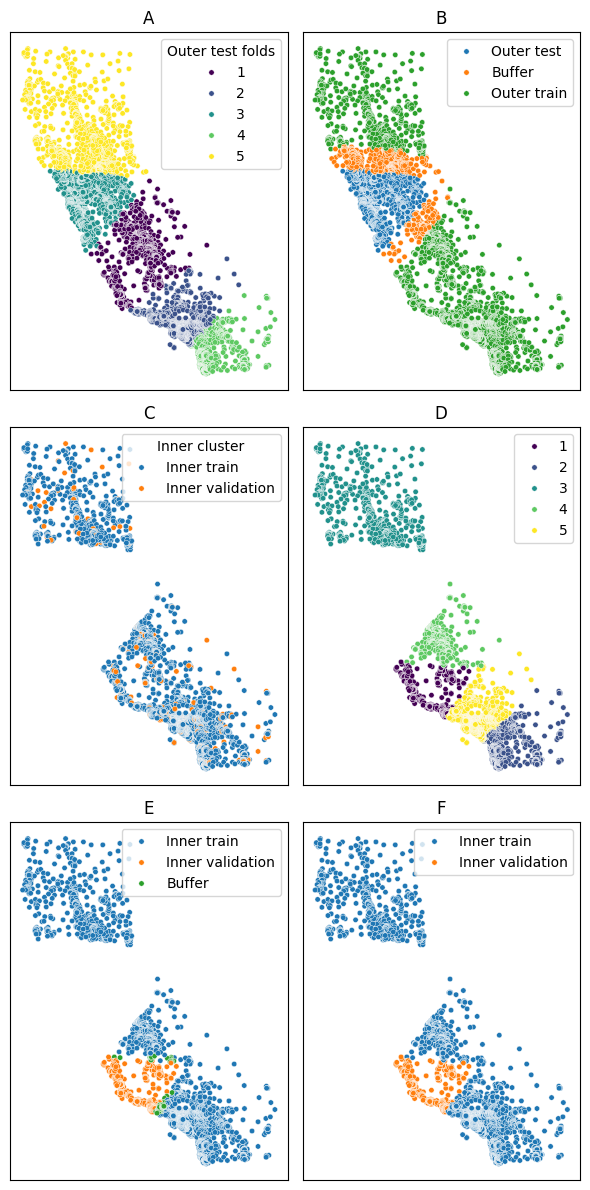

In [3]:
# Loading data for plots
cali_outer_folds = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_housing/cali_plots_outer_folds.csv')
cali_inner_folds = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_housing/cali_plots_inner_folds.csv')
# Changing name of inner test to inner validation for more clarity
cali_inner_folds.loc[cali_inner_folds['inner_group_spat'] == 'Inner test', 'inner_group_spat'] = 'Inner validation'
cali_inner_folds.loc[cali_inner_folds['inner_group_rand'] == 'Inner test', 'inner_group_rand'] = 'Inner validation'

# Create a 3x2 grid for the subplots
fig, axs = plt.subplots(3, 2, figsize=(6, 12))

# Plot 1
sns.scatterplot(data=cali_outer_folds, x='x', y='y', hue='cluster', palette='viridis', s=15, ax=axs[0,0])
axs[0,0].set(xlabel=None, ylabel=None)
axs[0,0].legend().set_title('Outer test folds')
axs[0,0].set_title('A')
axs[0,0].tick_params(left=False, bottom=False)  # Remove tick marks
axs[0,0].set_xticklabels([])  # Remove x-axis values
axs[0,0].set_yticklabels([])  # Remove y-axis values

# Plot 2
sns.scatterplot(data=cali_outer_folds, x='x', y='y', hue='outer_group', s=15, ax=axs[0,1])
axs[0,1].set(xlabel=None, ylabel=None)
axs[0,1].legend().set_title(None)
axs[0,1].set_title('B')
axs[0,1].tick_params(left=False, bottom=False)  # Remove tick marks
axs[0,1].set_xticklabels([])  # Remove x-axis values
axs[0,1].set_yticklabels([])  # Remove y-axis values

# Plot 3
sns.scatterplot(data=cali_inner_folds, x='x', y='y', hue='inner_group_rand', s=15, ax=axs[1, 0])
axs[1, 0].set(xlabel=None, ylabel=None)
axs[1, 0].legend().set_title('Inner cluster')
axs[1, 0].set_title('C')
axs[1, 0].tick_params(left=False, bottom=False)
axs[1, 0].set_xticklabels([])
axs[1, 0].set_yticklabels([])


# Plot 4
sns.scatterplot(data=cali_inner_folds, x='x', y='y', hue='cluster2', palette='viridis', s=15, ax=axs[1, 1])
axs[1, 1].set(xlabel=None, ylabel=None)
axs[1, 1].legend().set_title(None)
axs[1, 1].set_title('D')
axs[1, 1].tick_params(left=False, bottom=False)
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])

# Plot 5
sns.scatterplot(data=cali_inner_folds, x='x', y='y', hue='inner_group_spat', s=15, ax=axs[2, 0])
axs[2, 0].set(xlabel=None, ylabel=None)
axs[2, 0].legend().set_title(None)
axs[2, 0].set_title('E')
axs[2, 0].tick_params(left=False, bottom=False)
axs[2, 0].set_xticklabels([])
axs[2, 0].set_yticklabels([])

# Prepare data for Plot 4
cali_inner_folds_no_buff = cali_inner_folds.copy()
cali_inner_folds_no_buff.loc[cali_inner_folds_no_buff['inner_group_spat'] == 'Buffer', 'inner_group_spat'] = 'Inner train'

# Plot 6
sns.scatterplot(data=cali_inner_folds_no_buff, x='x', y='y', hue='inner_group_spat', s=15, ax=axs[2, 1])
axs[2, 1].set(xlabel=None, ylabel=None)
axs[2, 1].legend().set_title(None)
axs[2, 1].set_title('F')
axs[2, 1].tick_params(left=False, bottom=False)
axs[2, 1].set_xticklabels([])
axs[2, 1].set_yticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()


### Plots showing difference in mean RMSE between valid and test

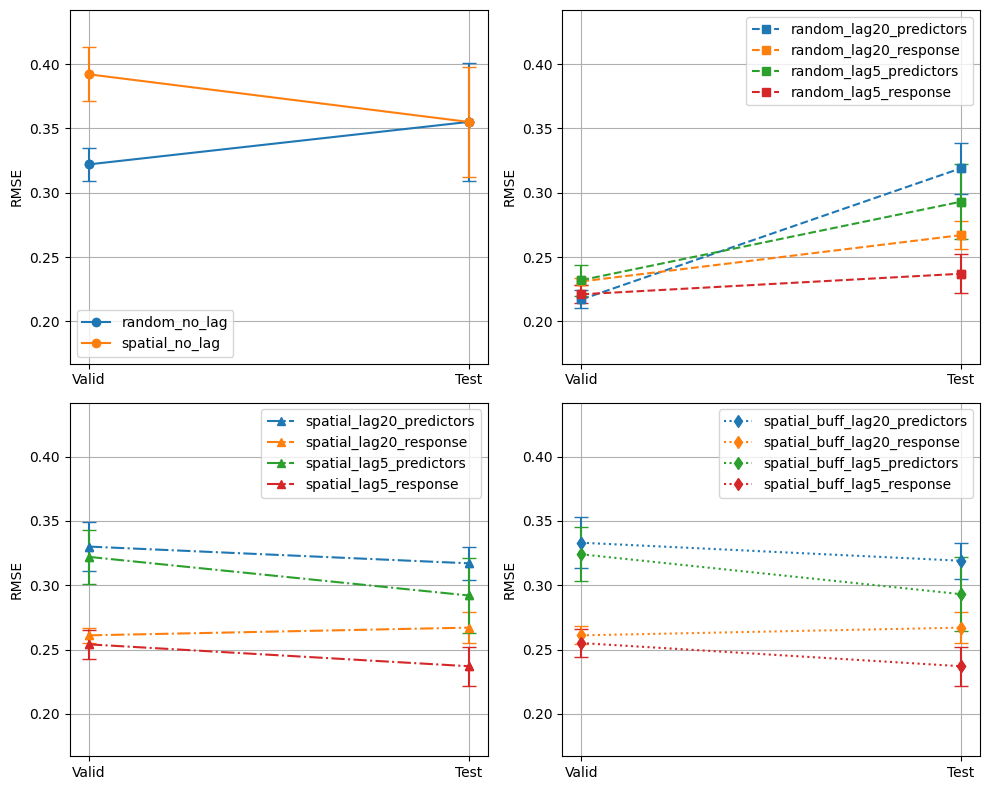

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/cali_rmse_results.csv')

# Define the model categories
categories = {
    'Random No Lag & Spatial No Lag': ['random_no_lag', 'spatial_no_lag'],
    'Random Lag': ['random_lag20_predictors', 'random_lag20_response', 'random_lag5_predictors', 'random_lag5_response'],
    'Spatial Lag': ['spatial_lag20_predictors', 'spatial_lag20_response', 'spatial_lag5_predictors', 'spatial_lag5_response'],
    'Spatial Buff Lag': ['spatial_buff_lag20_predictors', 'spatial_buff_lag20_response', 'spatial_buff_lag5_predictors', 'spatial_buff_lag5_response']
}

# Define the plot styles for each category
styles = {
    'Random No Lag & Spatial No Lag': {'marker': 'o', 'linestyle': '-'},
    'Random Lag': {'marker': 's', 'linestyle': '--'},
    'Spatial Lag': {'marker': '^', 'linestyle': '-.'},
    'Spatial Buff Lag': {'marker': 'd', 'linestyle': ':'}
}

# Color palette from the residuals plot
palette = sns.color_palette("tab10", len(df))

# Create the subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Define the y-axis range for consistency
y_min = min(df['valid_mean_rmse'].min(), df['test_mean_rmse'].min()) - 0.05
y_max = max(df['valid_mean_rmse'].max(), df['test_mean_rmse'].max()) + 0.05

# Plot each category in a separate subplot
for ax, (category, models) in zip(axes, categories.items()):
    for i, model in enumerate(models):
        row = df[df['model'] == model].iloc[0]
        rmse_values = [row['valid_mean_rmse'], row['test_mean_rmse']]
        se_values = [row['valid_se'], row['test_se']]
        distances = ['Valid', 'Test']
        style = styles[category]
        color = palette[i]

        # Plot lines connecting valid_mean_rmse and test_mean_rmse for each model
        ax.plot(distances, rmse_values, marker=style['marker'], linestyle=style['linestyle'], color=color, label=model)

        # Plot valid_mean_rmse with error bars
        ax.errorbar('Valid', row['valid_mean_rmse'], yerr=row['valid_se'], fmt=style['marker'], color=color, capsize=5, linestyle='None')

        # Plot test_mean_rmse with error bars
        ax.errorbar('Test', row['test_mean_rmse'], yerr=row['test_se'], fmt=style['marker'], color=color, capsize=5, linestyle='None')

    ax.set_ylim([y_min, y_max])
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

### Plot showing difference in test - valid with 95% CI

---



In [5]:
rmse_data = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/cali_rmse_results.csv')
rmse_data

,model,valid_mean_rmse,valid_se,test_mean_rmse,test_se,mean_valid_test_diff,valid_test_diff_se,t_value,p_value,holm_p_value
0,random_lag20_predictors,0.217,0.007,0.319,0.020,0.099,0.009,10.563,0.000,0.000
1,random_lag20_response,0.231,0.003,0.267,0.011,0.035,0.005,6.473,0.000,0.000
2,random_lag5_predictors,0.232,0.012,0.293,0.029,0.057,0.014,4.018,0.004,0.048
3,random_lag5_response,0.221,0.007,0.237,0.015,0.014,0.007,1.894,0.095,0.581
4,random_no_lag,0.322,0.013,0.355,0.046,0.026,0.021,1.217,0.258,0.774
5,spatial_buff_lag20_predictors,0.333,0.020,0.319,0.014,-0.021,0.011,-1.980,0.083,0.581
6,spatial_buff_lag20_response,0.261,0.007,0.267,0.012,0.003,0.006,0.548,0.599,0.940
7,spatial_buff_lag5_predictors,0.324,0.021,0.293,0.029,-0.037,0.016,-2.323,0.049,0.539
8,spatial_buff_lag5_response,0.255,0.011,0.237,0.015,-0.020,0.009,-2.289,0.051,0.539
9,spatial_lag20_predictors,0.330,0.019,0.317,0.013,-0.020,0.011,-1.929,0.090,0.581


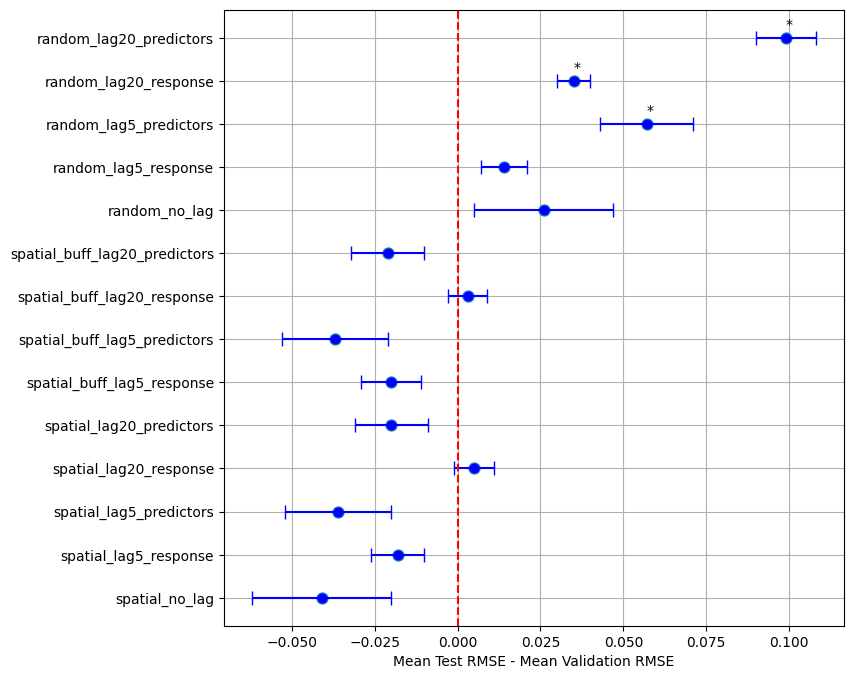

In [6]:
# Plot of mean diff (test RMSE - valid RMSE)
# Load data
rmse_data = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/cali_rmse_results.csv')

# Calculate the error margins correctly
rmse_data['Error_Lower'] = rmse_data['valid_test_diff_se']
rmse_data['Error_Upper'] = rmse_data['valid_test_diff_se']

# Create the (2, n) array for xerr
xerr = np.array([rmse_data['Error_Lower'].values, rmse_data['Error_Upper'].values])

# Plot with seaborn
plt.figure(figsize=(8, 8))
sns.pointplot(x='mean_valid_test_diff', y='model', data=rmse_data, capsize=0.1,
              err_kws={'linewidth': 1}, errorbar=None, linestyles='')

# Add error bars manually
plt.errorbar(x=rmse_data['mean_valid_test_diff'], y=rmse_data['model'], xerr=xerr, fmt='o', color='b', capsize=5)

# Add vertical line at zero
plt.axvline(x=0, color='red', linestyle='--')

# Add asterisks to significant points
for i, row in rmse_data.iterrows():
    if row['holm_p_value'] < 0.05 or row['holm_p_value'] == 0.05:
        plt.text(row['mean_valid_test_diff'], i -0.3, '*', color='black', ha='left', va='center')

plt.xlabel('Mean Test RMSE - Mean Validation RMSE')
plt.ylabel('')
plt.grid(True)
plt.show()



### Plot showing differences in valid RMSE for different CV approaches

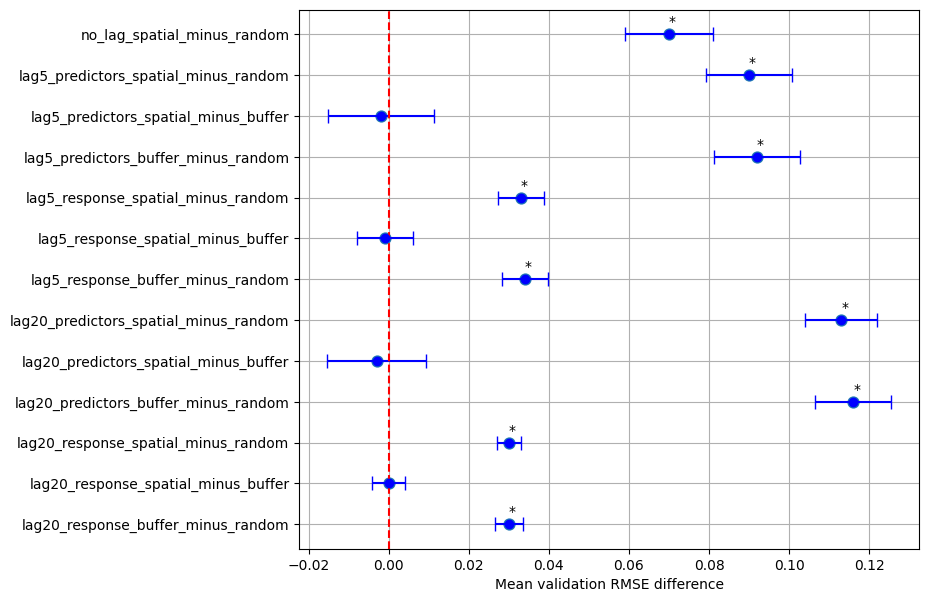

In [7]:
###### Plot with differnce in mean validation RMSE between models
df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/valid_diff.csv')

# Correct the column name if it was misspelled
df.rename(columns={'differnce': 'difference'}, inplace=True)

# Plot style setup
plt.figure(figsize=(8, 7))

# Calculate the error margins correctly
df['Error_Lower'] = df['diff_se']
df['Error_Upper'] = df['diff_se']

# Create the (2, n) array for xerr
xerr = np.array([df['Error_Lower'].values, df['Error_Upper'].values])

sns.pointplot(x='difference', y='comparison', data=df, capsize=0.1,
              err_kws={'linewidth': 1}, errorbar=None, linestyles='')

# Add error bars manually
plt.errorbar(x=df['difference'], y=df['comparison'], xerr=xerr, fmt='o', color='b', capsize=5)

# Add vertical line at zero
plt.axvline(x=0, color='red', linestyle='--')

# Add asterisks to significant points
for i, row in df.iterrows():
    if row['holm_p_value'] < 0.05 or row['holm_p_value'] == 0.05:
        plt.text(row['difference'], i -0.3, '*', color='black', ha='left', va='center')

plt.xlabel('Mean validation RMSE difference')
plt.ylabel('')
plt.grid(True)
plt.show()

### Plot showing difference in test RMSE for different CV approaches

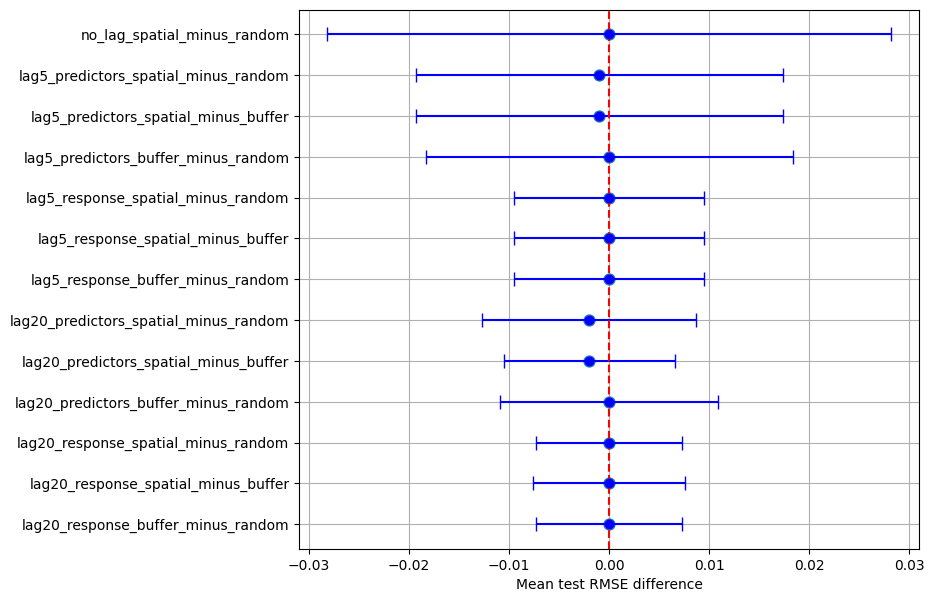

In [8]:
###### Plot with differnce in mean test RMSE between models
df = pd.read_csv('https://raw.githubusercontent.com/MarkMData/Dissertation-data/main/cali_results/test_diff.csv')

# Correct the column name if it was misspelled
df.rename(columns={'differnce': 'difference'}, inplace=True)

# Plot style setup
plt.figure(figsize=(8, 7))

# Calculate the error margins correctly
df['Error_Lower'] = df['diff_se']
df['Error_Upper'] = df['diff_se']

# Create the (2, n) array for xerr
xerr = np.array([df['Error_Lower'].values, df['Error_Upper'].values])

sns.pointplot(x='difference', y='comparison', data=df, capsize=0.1,
              err_kws={'linewidth': 1}, errorbar=None, linestyles='')

# Add error bars manually
plt.errorbar(x=df['difference'], y=df['comparison'], xerr=xerr, fmt='o', color='b', capsize=5)

# Add vertical line at zero
plt.axvline(x=0, color='red', linestyle='--')

# Add asterisks to significant points
for i, row in df.iterrows():
    if row['holm_p_value'] < 0.05 or row['holm_p_value'] == 0.05:
        plt.text(row['difference'], i -0.3, '*', color='black', ha='left', va='center')

plt.xlabel('Mean test RMSE difference')
plt.ylabel('')
plt.grid(True)
plt.show()